In [1]:
!pip install seaborn
!pip install pomegranate

     |████████████████████████████████| 215 kB 1.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 12.6 MB 3.3 MB/s eta 0:00:01    |█████████                       | 3.5 MB 1.9 MB/s eta 0:00:05
     |████████████████████████████████| 1.6 MB 3.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [3]:
import pomegranate as pg
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer

# Problem

Semi-supervised is a training methodology where we have a mixture of data that is labelled and unlabeled.

The key issue is that labeled data is not always available and it's expensive to carefully label everything

Semi-supervised learning infers labels for unlabled data based on the labels that are available.

This colab demonstrates semi-supervised learning using SciKit learn on breast cancer dataset where we chunk our dataset into 3 segments - 33% labeled, 33% unlabeled, 33% test. The labeled data is used to label the unlabeled data and train the model. Finally, the 33% test data is used to test the accuracy of the labeling and training process.

We use 2 key algorithms from SciKit learn: Label Propagation and Label Spreading, and test it against a base LogR model for this binary classification problem.

# Download dataset and Preprocessing
Here we download the standard breast cancer dataset and then prune the number of columns to relevant features.

Additionally, we split the dataset into 3 sets - training (X_1), semi-supervised w/ missing labels(X_2), test(X_3)

In [4]:
np.random.seed(1)

In [5]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data['target']

In [6]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [8]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [9]:
df = shuffle(df, random_state=1)

In [10]:
X = df.drop(df.columns.difference(['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry', 'mean fractal dimension']), 1)
y = df.drop(df.columns.difference(['target']), 1)

In [11]:
X.head()

,mean radius,mean texture,mean smoothness,mean compactness,mean concavity,mean symmetry,mean fractal dimension
421,14.69,13.98,0.10310,0.18360,0.14500,0.2086,0.07406
47,13.17,18.66,0.11580,0.12310,0.12260,0.2128,0.06777
292,12.95,16.02,0.10050,0.07943,0.06155,0.1730,0.06470
186,18.31,18.58,0.08588,0.08468,0.08169,0.1621,0.05425
414,15.13,29.81,0.08320,0.04605,0.04686,0.1852,0.05294


In [12]:
y.head()

,target
421,1
47,0
292,1
186,0
414,0


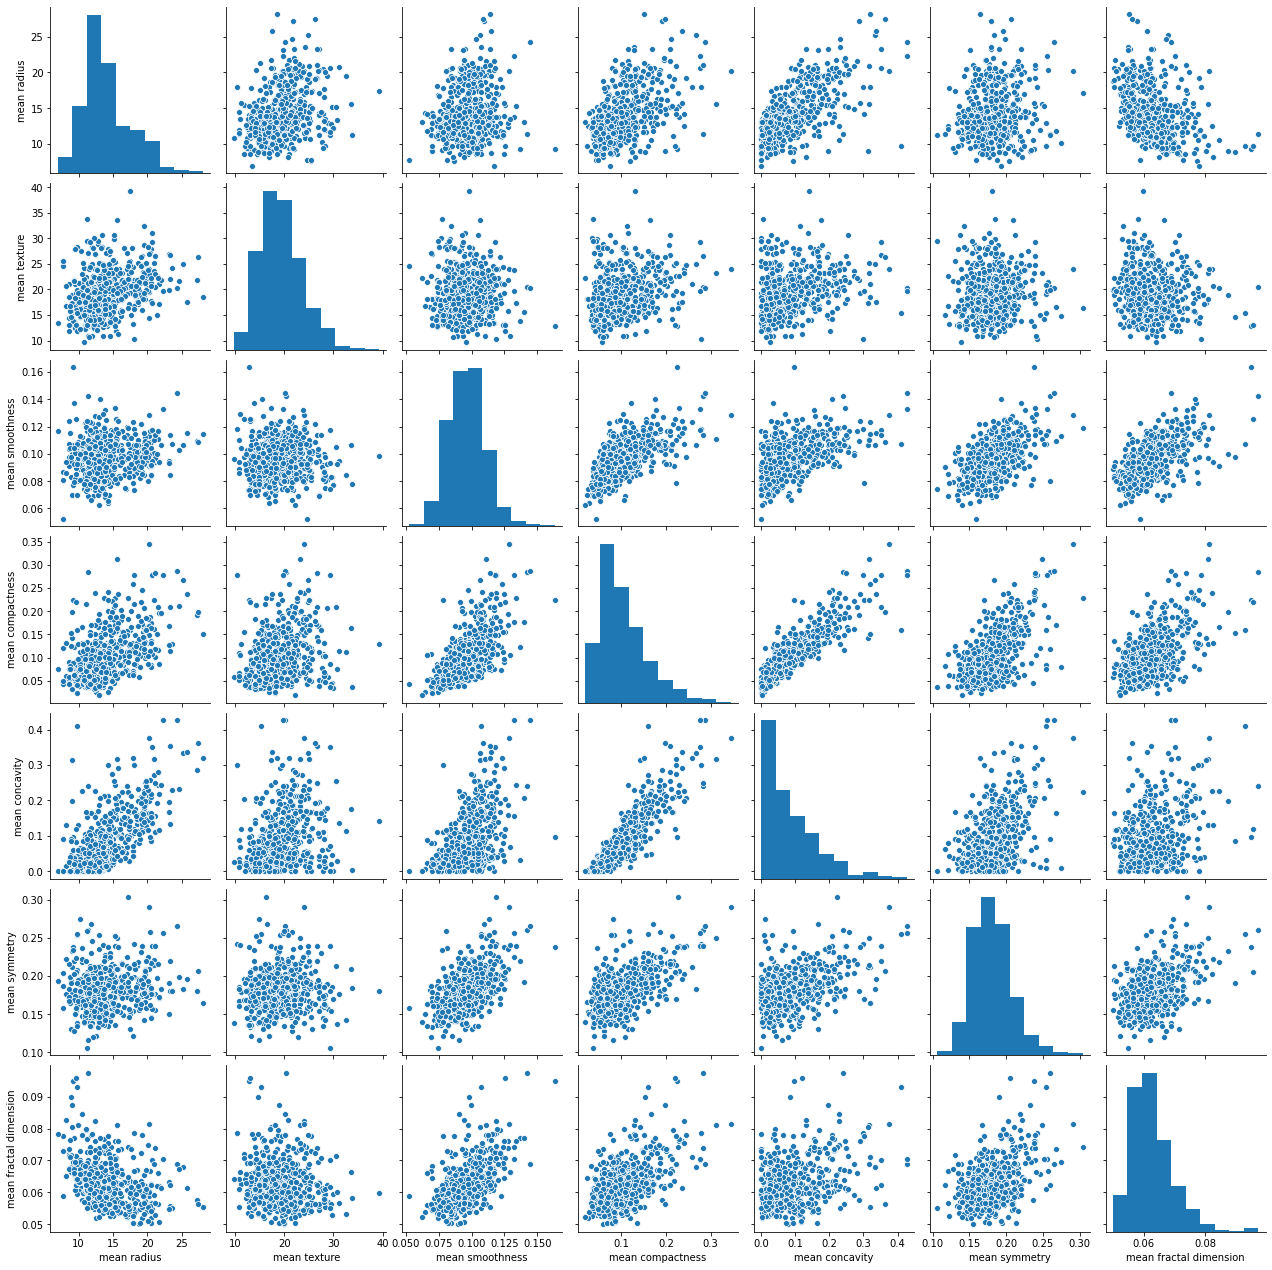

In [13]:
sns.pairplot(X)

In [14]:
X_1, X_2, X_3 = np.split(X, [int(.1*len(X)), int(.5*len(X))])
y_1, y_2, y_3 = np.split(y, [int(.1*len(y)), int(.5*len(y))])
y_2['target']=y_2['target'].apply(lambda x:-1)
y_1_2 = np.concatenate((y_1, y_2))
X_1_2 = np.concatenate((X_1, X_2))

In [15]:
y_1.head()

,target
421,1
47,0
292,1
186,0
414,0


# Label Prediction - Logistic Regression

Here we use logistic regression to do a simple train and test comparison.
We use the X_1 dataset to train LogR and compare accuracy on test dataset

In [16]:
index = ["Algorithm", "ROC AUC"]
results = pd.DataFrame(columns=index)

In [17]:
logr = LogisticRegression(random_state=1, class_weight='balanced')
logr.fit(X_1, y_1)
results = results.append(pd.Series(['Logistic Regression', roc_auc_score(y_3, logr.predict_proba(X_3)[:, 1])], index=index), ignore_index=True)
results

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Algorithm,ROC AUC
0,Logistic Regression,0.972269


# Label Prediction - Label Propagation

Reference: https://scikit-learn.org/stable/modules/label_propagation.html

In [18]:
def label_prop(kernel, params, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(20,10))
    n, g = 0,0
    roc_scores=[]
    if kernel == 'rbf':
        for g in params:
            lp=LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=10000, tol=0.0001)
            lp.fit(X_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(X_test)[:, 1]))
    if kernel == 'knn':
        for n in params:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=10000, tol=0.0001)
            lp.fit(X_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(X_test)[:, 1]))
    plt.figure(figsize=(16,8))
    plt.plot(params, roc_scores)
    plt.title("ROC with " + kernel + "kernel")
    plt.show()
    print("")

## RBF - Radial bias function
This is a kernel based technique which are higher dimensional mappings of data that are easier to computer the higher dimensional feature mappings directly. More generally, a kernal is a weighing function which assigns weights to neighboring points based on distance to the query point.

The RBF kernel, or Gaussian kernal is in the form of a radial bias function

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/loc

<Figure size 1440x720 with 0 Axes>

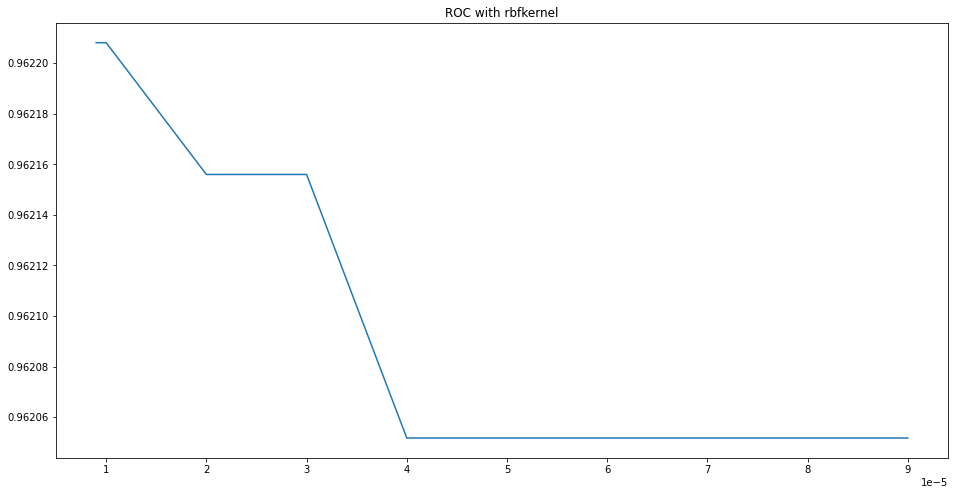

In [19]:
gamma=[9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5]
label_prop('rbf', gamma, X_1_2, X_3, y_1_2, y_3)

Here we see that the first value in our list of gammas gives us the most accuracy. This value was *9e-6*

In [23]:
results = results.append(pd.Series(['Label Propagation RBF', "0.9622"], index=index), ignore_index=True)

## KNN Kernel is the K nearest neighbors kernel
The KNN kernel is based on the k-nearest neighbors technique where an estimate is formed by averaging over the 'k' nearest data points

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/loc

<Figure size 1440x720 with 0 Axes>

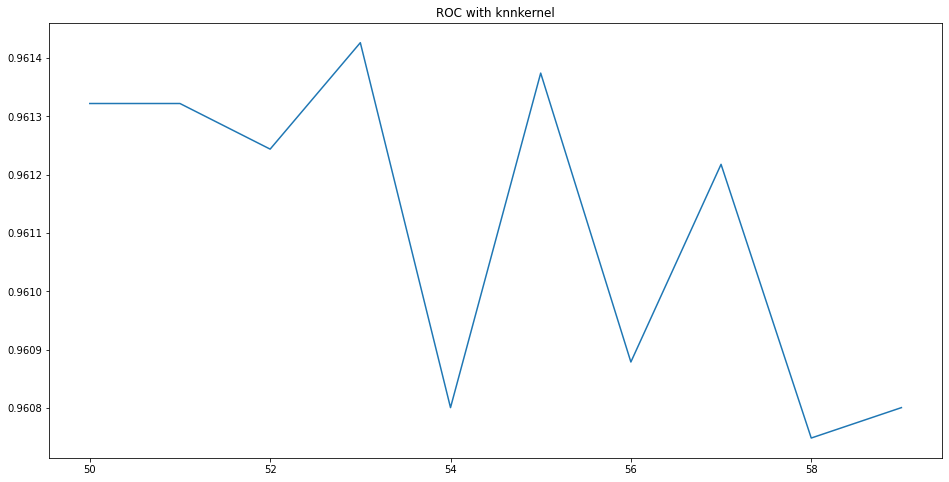

In [20]:
ns = list(range(50,60))
label_prop('knn', ns, X_1_2, X_3, y_1_2, y_3)

Here we see that the ns value of 53 gives us the best results with the accuracy of 0.9614

In [25]:
results = results.append(pd.Series(['Label Propagation KNN', "0.9614"], index=index), ignore_index=True)

# Label Prediction - Label Spreading

In [32]:
def labels_spread_test(kernel, hyperparam, alphas, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(20,10))
    n, g = 0, 0
    roc_scores = []
    if kernel == 'rbf':
        g = hypterparam
    if kernel == 'knn':
        n = hyperparam
    for alpha in alphas:
        ls = LabelSpreading(kernel=kernel, n_neighbors=n, gamma=g, alpha=alpha, max_iter=1000, tol=0.001)
        ls.fit(X_train, y_train)
        roc_scores.append(roc_auc_score(y_test, ls.predict_proba(X_test)[:,1]))
    plt.figure(figsize=(16,8))
    plt.plot(alphas, roc_scores)
    plt.title('Label Spreading ROC AUC with ' + kernel + ' kernel')
    plt.show()
    print('Best metrics value is at {}'.format(alphas[np.argmax(roc_scores)]))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/loc

<Figure size 1440x720 with 0 Axes>

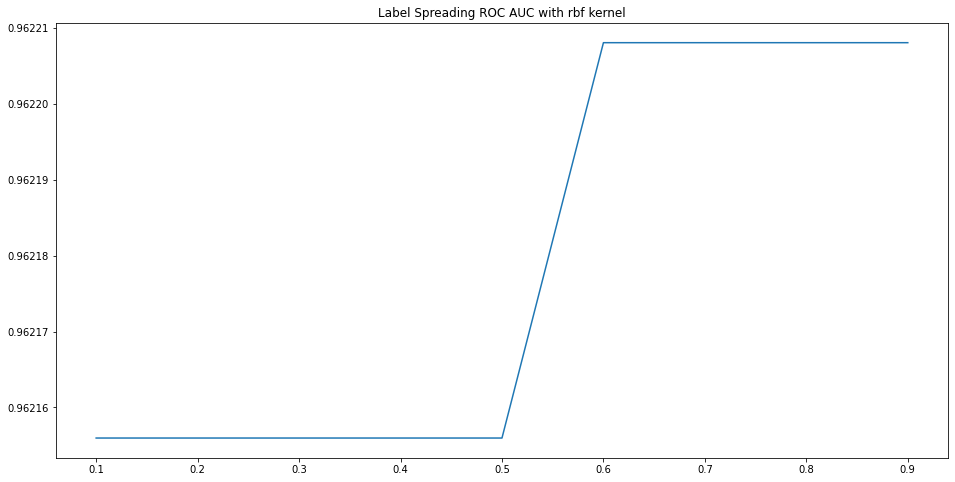

Best metrics value is at 0.6


In [30]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  
labels_spread_test('rbf', 1e-5, alphas, X_1_2, X_3, y_1_2, y_3)

In [34]:
results = results.append(pd.Series(['Label Spreading RBF', "0.96221"], index=index), ignore_index=True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/loc

<Figure size 1440x720 with 0 Axes>

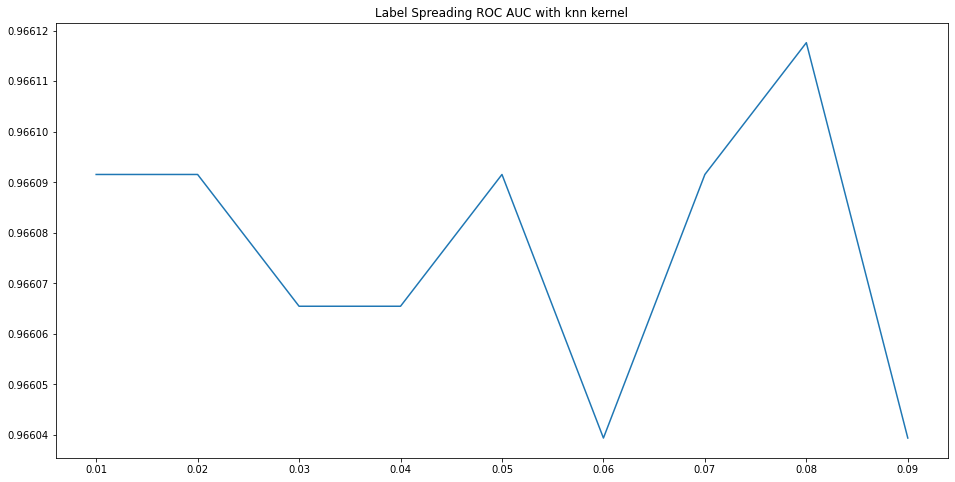

Best metrics value is at 0.08


In [33]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]  
labels_spread_test('knn', 53, alphas, X_1_2, X_3, y_1_2, y_3)

In [36]:
results = results.append(pd.Series(['Label Spreading KNN', "0.96612"], index=index), ignore_index=True)

In [37]:
results

,Algorithm,ROC AUC
0,Logistic Regression,0.972269
1,Label Propagation RBF,0.9622
2,Label Propagation KNN,0.9614
3,Label Spreading RBF,0.96221
4,Label Spreading KNN,0.96612


From our table, we can see that for predicting binary labels in semi-supervised learning, logistic regression classifier performs better than Label Propagation and Label Spreading.

It is important to note that these are various techniques that can be used to label unlabled data, while previously having some labeled data. The labeled data can then be used for classification, regression or clustering in a production/live scenario

Reference: https://www.kaggle.com/altprof/basic-semi-supervised-learning-models